In [1]:
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')
import run_six_utils as rsu
import lsst.afw.display as afwDisplay
import lsst.daf.butler as daf_butler
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.pyplot as plt
import numpy as np
import myutils_ar.myutils as myu
import eo_pipe

In [2]:
# repo = '/repo/main'
# operator = 'lsstccs'

# repo_arr = ['/repo/main','/repo/main','/repo/ir2','/repo/ir2']

# notable_detectors = ["R12_S20","R31_S01","R22_S01","R13_S01"]
# defect_list = ["BRIGHT_COLUMNS","BRIGHT_PIXELS"]

kwarg_dict = [{"alpha":.9,"ls":"-","marker":"+","markersize":10,"color":"red"},
              {"alpha":.9,"ls":"--","marker":"x","markersize":10,"color":"blue"},
              {"alpha":.9,"ls":"-.","marker":".","markersize":10,"color":"green"}]

## Using utils in `myutils.py` and `run_six_utils.py` to study specific amps

In [3]:
# detector_amps = [("R11_S21",["C17"]), # Very bad amp, completely dead for Run 5
#                  ("R12_S20",["C17",   # In the BOT bad sensors page
#                              "C16"]), # In the BOT bad sensors page
detector_amps = [("R13_S01",["C17"]), # Centered at (4035,3115)
                 ("R13_S10",["C07"]), # Centered at (3929,1598)
                 ("R22_S01",["C11"]), # Centered at (644,2098)
                 ("R23_S10",["C13"]), # Centered at (1570,3760)
                 ("R31_S01",["C05"]), # Centered at (2966, 888)
                 ("R32_S10",["C04"])] # Centered at (2458, 294)

col_row =[(4035,3115),(3929,1598),(644,2098),(1570,3760),(2966, 888),(2458, 294)]

# ('12845','w_2023_22','/repo/main'),

run_week_repo = [('13162','w_2023_22','/repo/main'),
                 ('13401','w_2023_24','/repo/ir2'),
                 ('13550','w_2023_41','/repo/ir2')]  # Run 5, 6, run 6b.
weeklys = ['w_2023_22','w_2023_24','w_2023_41']
img_type = 'raw'
if_raw = -10
defect_datasets=["eoDarkDefects","eoBrightDefects"]
defect_dataset_path=["eo_dark_defects","eo_bright_defects"]
col_number = 2458
row_center = 294

makeInset = False
scale=1.6

make_mask = False

# col_adjustment = 292/246
# figure_kwargs = {"left": 0.125,"right": 0.9,"bottom": 0.1,"top": 0.9,"wspace": 0.2,"hspace": 0.2}

# Use col_adjustment to adjust padding for the column subplots and subplots_adjust

In [6]:
def criteriaMaker(image_type):
    if image_type=="BIAS":
        return {'IMGTYPE': 'BIAS'}
    elif image_type=="FLAT":
        return {'IMGTYPE': 'FLAT'}
    elif image_type=="DARK":
        return {'IMGTYPE': 'DARK',"EXPTIME":30.0}

In [7]:
for IMG_TYPE in ["FLAT","DARK","BIAS"]:
# for IMG_TYPE in ["FLAT","DARK"]:
    criteria = criteriaMaker(IMG_TYPE)
    for make_mask in [False]:
        for makeInset in [True,False]:
        # for makeInset in [True]:
        
            for det_amp,column_row in zip(detector_amps,col_row):
                detector_str,amp_strs = det_amp
                col_number,row_center = column_row
                detector_num = myu.det_nums[detector_str]
                for amp_str in amp_strs:
                    # Make a new figure
            
                    fig = 'mtv';
                    plt.close(fig);
                    fig = plt.figure(fig);
            
                    # fig,axs = plt.subplots(1,len(run_week_repo),figsize=[5*len(run_week_repo)/3,5],sharey=True)
                    fig,axs = plt.subplots(1,2*len(run_week_repo),figsize=[5*len(run_week_repo),10],sharey=True)
                    
            
                    fig.suptitle(detector_str+" "+amp_str)
                    
                    for wkr,ax_iter in zip(run_week_repo,range(len(run_week_repo))):
                        run,week,repo = wkr
            
                        img_axs = axs[2*ax_iter+1]
                        col_axs = axs[ax_iter*2]

                        # Make a butler here in order to make image masks
            
                        collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
                        butler = daf_butler.Butler(repo,collections=collections) # Initializing a butler with the ir2 path and the above collections
                        registry = butler.registry
                        
                        img, detector_obj, amp = rsu.getAmp(repo,collections,[int(run)],img_type,detector_num,criteria,amp_str,oneRef=True)
                            #img_type,run,week,detector_str,amp_str,repo=repo,img_iterator=if_raw)
                        amp_array = img[amp.getBBox()].getImage().array
                        amp_min, amp_max = np.min(amp_array),np.max(amp_array)
                        box,minx,maxx,miny,maxy = rsu.getAmpCorners(amp)
                        if makeInset:
                            minx,maxx = col_number-10*scale,col_number+10*scale
                            miny,maxy = row_center-50*scale,row_center+50*scale
                            inset_array = amp_array[int(miny-amp.getBBox().minY):int(maxy - amp.getBBox().minY),int(minx-amp.getBBox().minX):int(maxx - amp.getBBox().minX)]
                            low_scale,high_scale = np.quantile(inset_array,[0.1,0.9])
                        else:
                            low_scale,high_scale = np.quantile(amp_array,[0.1,0.9])
                            
                            
                            
            
                        # Mask image here

                        if make_mask:
                            kwargs={
                                    "datasetType": "",
                                    "collections": "",
                                    "where":
                                    """
                                    instrument='LSSTCam' and 
                                    detector = {var}
                                    """.format(var=detector_num)
                                    }
                
                            for datasetType,defect_path in zip(defect_datasets,defect_dataset_path):
                                img.getMask().addMaskPlane(datasetType)
                                # here, add a new mask plane to add the mask.maskPixels to
                                kwargs['datasetType'] = datasetType
                                kwargs['collections'] = "u/lsstccs/"+defect_path+"_"+run+"_"+week
                                # print("Querying",datasetType,"for mask")
                                datasetRefs = list(registry.queryDatasets(**kwargs))
                                count = 0
                                for ref in datasetRefs:
                                    count+=1
                                if count!=1:
                                    print("Error with {}: too many defects for {}!".format(run,datasetType))
                                mask = butler.get(datasetRefs[0])
                                
                                mask.maskPixels(img,maskName=datasetType)
            
                        # End image masking 
                        
                        # add data to axes here
            
                        disp = afwDisplay.Display(fig)
                        disp.setImageColormap('inferno')
                        disp.frame.set_layout_engine('tight')
                        disp.frame.get_layout_engine().set(h_pad=.1, w_pad=.1, rect=(0,0.2, 1,0.8))
                        rsu.formatter(disp,kw=defect_datasets)
                        plt.sca(img_axs)
                        final_img = rsu.runISR(img).exposure
                        if not make_mask:
                            mtv_img = final_img
                        else:
                            mtv_img = final_img
                        # if makeInset:
                        #     disp.scale('asinh', np.min(inset_array),np.max(inset_array))
                        # else:
                        #     disp.scale('asinh', amp_min,amp_max)
                        # disp.scale("asinh",low_scale,high_scale)
                        disp.scale("asinh","zscale")
                        
                        disp.mtv(mtv_img)
                        
                        # End adding data
                        
                        # format amp image here
                        if img_type !="raw":            
                            img_exptime = final_img.getMetadata().toDict()["CPP_INPUT_EXPT_0"]
                        else:
                            img_exptime = final_img.metadata.toDict()["EXPTIME"]
                        img_axs.set_title("{}\nExpTime: {}s".format(run,img_exptime))
                        img_axs.set_xlabel("Serial Register")
                        
                        img_axs.set_xlim(minx,maxx)
                        img_axs.set_xticks(np.arange(minx,maxx+1,step=int(np.floor((maxx-minx)/2))))
                        img_axs.set_ylim(miny,maxy)
                        img_axs.set_yticks(np.arange(miny,maxy,step=int(np.floor((maxy-miny)/6))))
                        
                        
                        # plt.set_clim()
                        # disp.frame.set_layout_engine('tight')
            
                        # Now do the column axs
                        plt.sca(col_axs)
                        col_axs.plot(final_img.image.array.T[col_number],np.arange(len(final_img.image.array.T[col_number])))
            
                        # format the col_axs
                        col_axs.set_title("{}\n{}: Column {}".format(IMG_TYPE,run,col_number))
                        col_axs.set_xlabel("Flux [e-]")
                        col_axs.grid()
                        col_axs.set_yticks(np.arange(miny,maxy,step=int(np.floor((maxy-miny)/6))))
                        # col_axs.set_xlim(int(1E4),int(1.2E5))
                        # col_axs.set_xticks(np.arange(int(1E4),int(1.2E5)+1,step=int(4E4)))
                        col_axs.xaxis.set_major_formatter(rsu.ticker.FormatStrFormatter('%0.0e'))
                        col_axs.set_ylim(miny,maxy)
            
                        if makeInset==False:                
                            plt.subplots_adjust(left=0,right=1,bottom=0.2,top=0.8,wspace=0.2,hspace=0.2)
                            
                        if makeInset==True:                
                            plt.subplots_adjust(left=0.2,right=0.8,bottom=0.2,top=0.8,wspace=0,hspace=0.2)
            
                    axs[0].set_ylabel("Parallel Register")
                    
                    # fig.set_constrained_layout(True)

                    xlim_low_old, xlim_high_old = 1E10,-1E10
                    for k in np.arange(0,6,step=2):
                        xlim_low, xlim_high = axs[k].get_xlim()
                        if xlim_low < xlim_low_old:
                            xlim_low_old = xlim_low
                        if xlim_high > xlim_high_old:
                            xlim_high_old = xlim_high
                    for j in np.arange(0,6,step=2):
                        axs[j].set_xlim(xlim_low_old,xlim_high_old)
                    
                    # fig.tight_layout()
                    
                    fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/AmpStudy/{}_{}_{}{}{}_{}.jpg".format(img_type,IMG_TYPE,"NoMask_" if make_mask==False else "WithMask_","" if makeInset==False else "inset_",detector_str,amp_str),dpi=200)
                    
                    fig.clear()
                    plt.close(fig)

<Figure size 640x480 with 0 Axes>

In [ ]:
img, detector_obj, amp = rsu.getAmp(repo,collections,[int(run)],img_type,detector_num,criteria,amp_str,oneRef=True)

In [6]:
rsu.getDetectorNumber(["R13_S01"])

array([55])

In [8]:
dc

{'SIMPLE': True,
 'EXTEND': True,
 'DATE': '2021-12-13T00:40:08.264',
 'MJD': 59561.027873425744,
 'RUNNUM': '13162',
 'CCD_MANU': 'E2V',
 'CCD_TYPE': 'CCD250',
 'TESTTYPE': 'BIAS',
 'IMGTYPE': 'BIAS',
 'DETSIZE': '[1:4096,1:4004]',
 'EXPTIME': 0.0,
 'BINX': 1,
 'BINY': 1,
 'CCDGAIN': 1.0,
 'CCDNOISE': 10.0,
 'DATE-OBS': '2021-12-13T00:40:08.182',
 'MJD-OBS': 59561.02787247673,
 'DATE-TRG': '2021-12-13T00:40:08.182',
 'MJD-TRG': 59561.02787247673,
 'IMAGETAG': '8e9423b89c852140',
 'CCDSLOT': 'S01',
 'RAFTBAY': 'R13',
 'FIRMWARE': '31395007',
 'PLATFORM': 'ir2-camera',
 'CONTNUM': '18edf90c',
 'DAQVERS': 'R5-V0.11 2021-11-03T15:13:45Z (fbaf2dd)',
 'DAQPART': 'camera',
 'DAQFOLD': 'raw',
 'DAQANNOT': '0 sec extra delay',
 'OBSID': 'MC_C_20211212_000177',
 'TELCODE': 'MC',
 'CONTRLLR': 'C',
 'DAYOBS': '20211212',
 'SEQNUM': 177,
 'HEADVER': 2,
 'INSTRUME': 'lsstCam',
 'TELESCOP': 'LSST',
 'TSTAND': 'BOT',
 'SEQFILE': 'FP_E2V_2s_ir2_v26.seq',
 'SEQCKSUM': '3099412345',
 'LSST_NUM': 'E2V-CC

In [17]:
for rwr in run_week_repo:
    run,week,repo = rwr
    allRefs = rsu.fetchAllRefs(repo,collections,[run],"raw",detector_num)
    recordDict = {"BIAS":[],"DARK":[],"FLAT":[]}
    print("Run {}".format(run))
    for r in allRefs:
        dc = rsu.getMetadataDict(r,rsu.makeButler(repo,collections))
        # if :
        if "FILTER" not in dc.keys() or dc["IMGTYPE"] not in recordDict.keys():
            continue
        else:
            
            if dc["FILTER"] not in recordDict[dc["IMGTYPE"]]:
                recordDict[dc["IMGTYPE"]].append(dc["FILTER"])
    print(recordDict)

Run 13162
{'BIAS': ['SDSSi'], 'DARK': ['SDSSi'], 'FLAT': ['SDSSi', 'SDSSg', 'SDSSr', 'SDSSu', 'SDSSY', 'SDSSz']}
Run 13401
{'BIAS': ['ef_43'], 'DARK': ['ef_43'], 'FLAT': ['ef_43']}


In [20]:
print(recordDict)

{'BIAS': ['ef_43'], 'DARK': ['ef_43'], 'FLAT': ['ef_43']}


In [ ]:
allRefs = rsu.fetchAllRefs(repo,collections,[13550],"raw",detector_num)
recordDict = {"BIAS":[],"DARK":[],"FLAT":[]}
print("Run {}".format(run))
for r in allRefs:
    dc = rsu.getMetadataDict(r,rsu.makeButler(repo,collections))
    if dc["IMGTYPE"] not in recordDict.keys():
        continue
    else:
        if dc["EXPTIME"] not in recordDict[dc["IMGTYPE"]]:
            recordDict[dcc["IMGTYPE"]].append(dc["EXPTIME"])
print(recordDict)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/ipykernel/kernelbase.py:442: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  self.log.error("KeyboardInterrupt caught in kernel.")


### Make a plot that looks through all the refs along a given column that you specify, try to use that to identify if one/multiple raws are contributing to the bright defects

In [8]:
allRefs = rsu.fetchAllRefs(repo,collections,[13162],"raw",55)

In [22]:
repo,collections

('/repo/ir2', ['LSSTCam/raw/all', 'LSSTCam/calib'])

In [14]:
exposrr = rsu.makeButler(repo,collections).get(allRefs[2])

In [22]:
allRefs

[DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200255, band: 'y', physical_filter: 'SDSSY'}, run='LSSTCam/raw/all', id=44111c77-088a-5f46-8723-084ae111ef16),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200251, band: 'g', physical_filter: 'SDSSg'}, run='LSSTCam/raw/all', id=a61f25ed-695d-59ba-b3d7-27e4b789a9e4),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200240, band: 'i', physical_filter: 'SDSSi'}, run='LSSTCam/raw/all', id=1d1c0500-1bce-5f14-883a-26693a4fddea),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200241, band: 'i', physical_filter: 'SDSSi'}, run='

In [21]:
exposrr.getMetadata().toDict()

{'SIMPLE': True,
 'EXTEND': True,
 'DATE': '2021-12-13T03:56:44.965',
 'MJD': 59561.164409317076,
 'RUNNUM': '13162',
 'CCD_MANU': 'E2V',
 'CCD_TYPE': 'CCD250',
 'TESTTYPE': 'SFLAT',
 'IMGTYPE': 'FLAT',
 'DETSIZE': '[1:4096,1:4004]',
 'EXPTIME': 32.8319,
 'BINX': 1,
 'BINY': 1,
 'CCDGAIN': 1.0,
 'CCDNOISE': 10.0,
 'DATE-OBS': '2021-12-13T03:56:44.957',
 'MJD-OBS': 59561.16440922441,
 'DATE-TRG': '2021-12-13T03:56:44.957',
 'MJD-TRG': 59561.16440922441,
 'IMAGETAG': '774c466852cbc8ad',
 'CCDSLOT': 'S01',
 'RAFTBAY': 'R13',
 'FIRMWARE': '31395007',
 'PLATFORM': 'ir2-camera',
 'CONTNUM': '18edf90c',
 'DAQVERS': 'R5-V0.11 2021-11-03T15:13:45Z (fbaf2dd)',
 'DAQPART': 'camera',
 'DAQFOLD': 'raw',
 'DAQANNOT': '',
 'OBSID': 'MC_C_20211212_000240',
 'TELCODE': 'MC',
 'CONTRLLR': 'C',
 'DAYOBS': '20211212',
 'SEQNUM': 240,
 'HEADVER': 2,
 'INSTRUME': 'lsstCam',
 'TELESCOP': 'LSST',
 'TSTAND': 'BOT',
 'SEQFILE': 'FP_E2V_2s_ir2_v26.seq',
 'SEQCKSUM': '3099412345',
 'LSST_NUM': 'E2V-CCD250-331',
 

In [11]:
rsu.getMetadataDict(allRefs[2],rsu.makeButler(repo,collections))

{'SIMPLE': True,
 'EXTEND': True,
 'DATE': '2021-12-13T03:56:44.965',
 'MJD': 59561.164409317076,
 'RUNNUM': '13162',
 'CCD_MANU': 'E2V',
 'CCD_TYPE': 'CCD250',
 'TESTTYPE': 'SFLAT',
 'IMGTYPE': 'FLAT',
 'DETSIZE': '[1:4096,1:4004]',
 'EXPTIME': 32.8319,
 'BINX': 1,
 'BINY': 1,
 'CCDGAIN': 1.0,
 'CCDNOISE': 10.0,
 'DATE-OBS': '2021-12-13T03:56:44.957',
 'MJD-OBS': 59561.16440922441,
 'DATE-TRG': '2021-12-13T03:56:44.957',
 'MJD-TRG': 59561.16440922441,
 'IMAGETAG': '774c466852cbc8ad',
 'CCDSLOT': 'S01',
 'RAFTBAY': 'R13',
 'FIRMWARE': '31395007',
 'PLATFORM': 'ir2-camera',
 'CONTNUM': '18edf90c',
 'DAQVERS': 'R5-V0.11 2021-11-03T15:13:45Z (fbaf2dd)',
 'DAQPART': 'camera',
 'DAQFOLD': 'raw',
 'DAQANNOT': '',
 'OBSID': 'MC_C_20211212_000240',
 'TELCODE': 'MC',
 'CONTRLLR': 'C',
 'DAYOBS': '20211212',
 'SEQNUM': 240,
 'HEADVER': 2,
 'INSTRUME': 'lsstCam',
 'TELESCOP': 'LSST',
 'TSTAND': 'BOT',
 'SEQFILE': 'FP_E2V_2s_ir2_v26.seq',
 'SEQCKSUM': '3099412345',
 'LSST_NUM': 'E2V-CCD250-331',
 

In [33]:
mDict = rsu.getMetadataDict(allRefs[-5],rsu.makeButler(repo,collections))

In [38]:
mDict["FILTER1"]

'nm750'

In [23]:
for r in rsu.fetchAllRefs(repo,collections,[13550],"raw",90):
    mDict = rsu.getMetadataDict(allRefs[0],rsu.makeButler(repo,collections))
    print(mDict["FILTER"],mDict["IMGTYPE"])

ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS

KeyboardInterrupt: 

In [137]:
allRefs = rsu.fetchAllRefs(repo,collections,[13550],"raw",90)

ite = 0
for r in allRefs:
    if str(r.id) == "522e1883-fcdc-585d-becb-725905446ef6":
        print(r,ite)
    ite+=1

raw@{instrument: 'LSSTCam', detector: 90, exposure: 2023111600082, band: 'white', physical_filter: 'ef_43~HIGH'} [sc=Exposure] (run=LSSTCam/raw/all id=522e1883-fcdc-585d-becb-725905446ef6) 227


In [181]:
reference_ref = allRefs[227]

<Figure size 640x480 with 0 Axes>

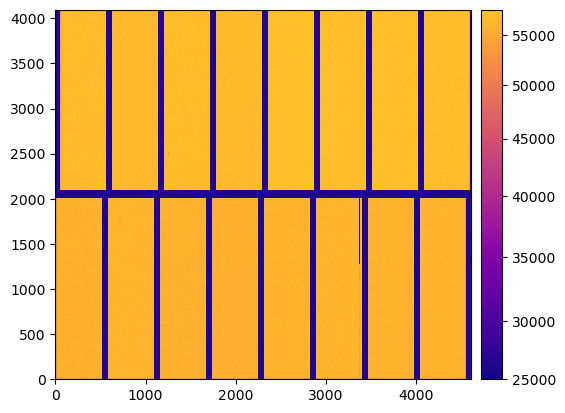

In [194]:
image = rsu.makeButler(repo,collections).get(reference_ref)
fig = 'mtv';
plt.close(fig);
fig = plt.figure(fig);

fig,axs = plt.subplots()
# fig.suptitle("{var0}, detector {var1}, Run {var3}".format(var0=img_type,var1=90,var3=run_number))

disp = afwDisplay.Display(fig)
disp.setImageColormap('plasma')
disp.scale('asinh','zscale',Q=1)

rsu.formatter(disp)
plt.sca(axs)

disp.mtv(image)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f909e349580> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

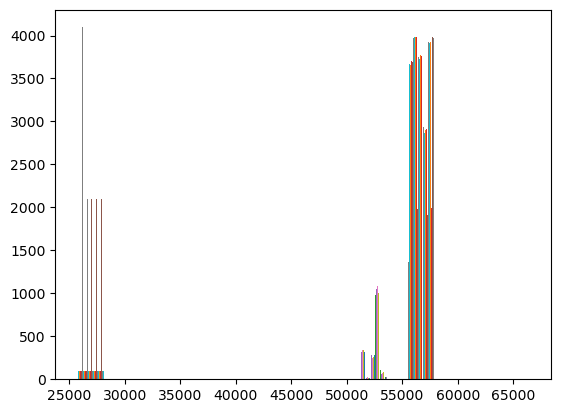

In [183]:
plt.hist(image.getImage().array)